# Single Crane as Part of a Gantry Crane: Derivation of Equations of Motion and Simulation

Strongly inspired by Bolorkhuu Dariimaa (2017), Carsten Knoll (2021) 

This notebook requires the python packages `ipydex` and `symbtools`. To install these, one might use:

```

!pip install ipydex symbtools

```

---


In [1]:
%load_ext ipydex.displaytools

from sympy import sin, cos, Function
import numpy as npy
np = npy
import sympy as sp
import sys
import pickle
import numpy as np
import symbtools as st
from symbtools import modeltools as mt
import pickle
np.set_printoptions(precision=3, suppress=True)

from matplotlib import pyplot as plt
import time
time.ctime()

'Wed Apr  6 17:24:28 2022'

In [2]:
from sympy.interactive import printing
printing.init_printing()

Image:

<img src="single_crane_diagram.svg">

In [3]:
t = sp.Symbol('t')
params = sp.symbols('m0, m1, l1, g, d0, d1')

st.make_global(params)

# TODO: determine d0, d1
params_values = [(m0, 0.557), (m1, 0.1), (l1, 0.32), (g, 9.81),
                 (d0, 0.01), (d1, 0.01)]

F = sp.Symbol('F')

Np = 1 # number of passive coordinates
Nq = 1 # number of actuated coordinates
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))


aa = st.symb_vector("a1:{0}".format(Nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)


---

---

---

Meaning of the variables: absolut values!

$[p_1, q_1] = [\varphi_1, x_0]$

---

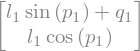

---

In [4]:
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

Rz = mt.Rz

# centers of masses -> S
# joints -> G

S0 = G0 = ex*q1 ##:

#G1 = G0 + Rz(p1)*ey*l1 ##:
# TODO: evaluate if ordinary definition of coordinate system is the better approach, so rotation matrix can be used
S1 = G1 =  G0 + l1*sp.Matrix([sp.sin(p1), sp.cos(p1)]) ##:


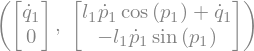

---

In [5]:
# Time derivatives of coordinates of the centers of masses
S0dt, S1dt = st.col_split(st.time_deriv(st.col_stack(S0, S1), ttheta)) ##:

In [6]:
# kinetic energy of the cart
T0 = 0.5 * m0 * qdot1**2
# kinetic energy of pendulum
T1 = 0.5 * m1 * (S1dt.T * S1dt)[0]

# total kinetic energy
T = T0 + T1

# total potential energy
V = g * m1 * (l1 - S1[1])

# viscous friction
# TODO: is this calculation correct?
R = 0.5 * d0 * qdot1**2 + 0.5 * d1 * pdot1**2

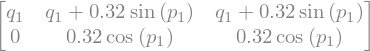

---

In [7]:
key_point_pos_expr = st.col_stack(G0, G1, S1).subs(params_values) ##:
key_point_pos_func = st.expr_to_func(ttheta, key_point_pos_expr, keep_shape=True)

### Visualization of kinematics (optional, just for didactic or debug purpose)

In [9]:
%matplotlib inline

def plot_func(p1, p2, p3, q1, lines=None, init=False):
    
    res_arr = key_point_pos_func(p1, p2, p3, q1)
    
    # joints
    xxg, yyg = res_arr[:, :4]
    
    # centers of mass
    xxs, yys = res_arr[:, 4:]
    
    
    # G0, G1, G2, S0, S1, S2 = res_arr.T    
    
    if lines is None:
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-1.3,1.3))
        ax.set_aspect('equal')
        

        line1, = ax.plot(xxg, yyg,"b-o")
        line2, = ax.plot(xxs, yys,"r.")
        
        if init:
            return fig, ax, line1, line2

    else:
        line1, line2 = lines
        line1.set_data(xxg, yyg)
        line2.set_data(xxs, yys)
        
        return line1, line2

from ipywidgets import interact
@interact(p1=(-4, 4, .1), p2=(-4, 4, .1), p3=(-4, 4, .1), q1=(-2, 2, .1))
def i_plot(p1, p2, p3, q1):
    plot_func(p1, p2, p3, q1)
    
    

interactive(children=(FloatSlider(value=0.0, description='p1', max=4.0, min=-4.0), FloatSlider(value=0.0, desc…

In [9]:
external_forces = [0, 0, 0, F] ##:

---

In [10]:


if 0:
    # Calculate the model based on lagrange equation (about 30s)
    %time mod = mt.generate_symbolic_model(T, V, ttheta, external_forces)
    
    # perform patial linearization such that system input is acceleration and not force (about 9min)
    %time mod.calc_coll_part_lin_state_eq()
    
    # write the model to disk to save time in the next run of the notebook
    with open("model_triple_pendulum_knoll.pcl", "wb") as pfile:
        pickle.dump(mod, pfile)
else:
    with open("model_triple_pendulum_knoll.pcl", "rb") as pfile:
        mod = pickle.load(pfile)

In [11]:
st.gradient(R, tthetad).smplf.T ##:

(st.gradient(R, tthetad).smplf.T) := ⎡  1.0⋅d₁⋅ṗ₁ + d₂⋅(ṗ₁ - ṗ₂)  ⎤
⎢                            ⎥
⎢-d₂⋅(ṗ₁ - ṗ₂) + d₃⋅(ṗ₂ - ṗ₃)⎥
⎢                            ⎥
⎢     1.0⋅d₃⋅(-ṗ₂ + ṗ₃)      ⎥
⎢                            ⎥
⎣             0              ⎦

---

In [12]:
rhs = mod.ff + mod.gg*mod.aa ##:S

---

In [13]:
# count ops -> how big is the expression?
rhs[4].co

In [15]:
# equations of motions generate LaTeX-Code for the video:
from symbtools import interactive_aux as ia
ia.adapted_latex(mod.eqns)

\left(\begin{matrix}
1.0 J_{1} \ddot{p}_{1} + 1.0 a_{1}^{2} m_{1} \ddot{p}_{1} - 1.0 a_{1} g m_{1} \sin{\left(p_{1} \right)} - 1.0 a_{1} m_{1} \ddot{q}_{1} \cos{\left(p_{1} \right)} + 1.0 a_{2} l_{1} m_{2} \ddot{p}_{2} \cos{\left(p_{1} - p_{2} \right)} + 1.0 a_{2} l_{1} m_{2} \dot{p}_{2}^{2} \sin{\left(p_{1} - p_{2} \right)} + 1.0 a_{2} l_{1} m_{3} \ddot{p}_{3} \cos{\left(p_{1} - p_{3} \right)} + 1.0 a_{2} l_{1} m_{3} \dot{p}_{3}^{2} \sin{\left(p_{1} - p_{3} \right)} - 1.0 g l_{1} m_{2} \sin{\left(p_{1} \right)} - 1.0 g l_{1} m_{3} \sin{\left(p_{1} \right)} + 1.0 l_{1}^{2} m_{2} \ddot{p}_{1} + 1.0 l_{1}^{2} m_{3} \ddot{p}_{1} + 1.0 l_{1} l_{2} m_{3} \ddot{p}_{2} \cos{\left(p_{1} - p_{2} \right)} + 1.0 l_{1} l_{2} m_{3} \dot{p}_{2}^{2} \sin{\left(p_{1} - p_{2} \right)} - 1.0 l_{1} m_{2} \ddot{q}_{1} \cos{\left(p_{1} \right)} - 1.0 l_{1} m_{3} \ddot{q}_{1} \cos{\left(p_{1} \right)}\\
1.0 J_{2} \ddot{p}_{2} + 1.0 a_{2}^{2} m_{2} \ddot{p}_{2} - 1.0 a_{2} g m_{2} \sin{\left(p_{2} \right)} +

In [16]:
mod.eqns

⎡                  2                                                          
⎢1.0⋅J₁⋅p̈₁ + 1.0⋅a₁ ⋅m₁⋅p̈₁ - a₁⋅g⋅m₁⋅sin(p₁) - a₁⋅m₁⋅q̈₁⋅cos(p₁) + 1.0⋅a₂⋅l₁
⎢                                                                             
⎢                                                2                            
⎢                              1.0⋅J₂⋅p̈₂ + 1.0⋅a₂ ⋅m₂⋅p̈₂ - a₂⋅g⋅m₂⋅sin(p₂) +
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                            ⎛
⎣                                                        -F + 1.0⋅m₀⋅q̈₁ + m₁⋅

                                  2                                           
⋅m₂⋅p̈₂⋅cos(p₁ - p₂) + 1.0⋅a₂⋅l₁⋅m₂⋅ṗ₂ ⋅sin(p₁ - p

In [17]:
rhs_v = rhs.subs(params_values) ##:S

---

In [18]:
# count_ops for each component (after substitution of numerical values)
rhs_v.co

⎡ 1 ⎤
⎢   ⎥
⎢ 1 ⎥
⎢   ⎥
⎢ 1 ⎥
⎢   ⎥
⎢ 1 ⎥
⎢   ⎥
⎢218⎥
⎢   ⎥
⎢270⎥
⎢   ⎥
⎢270⎥
⎢   ⎥
⎣ 1 ⎦

In [19]:
# which symbols are still occurring?
rhs_v.s

### Design of the Tranquilisation Controller

$\dot E = L_f E + L_g E \cdot a$

Due to conservation of energy and dissipation we have $L_f E \leq 0$. Through suitable choice of input signal $a$ the second term should also be made negative.

Example: $a = \mathtt{clip}\big(L_g E \cdot a_{max}, - a_{max}, a_{max}\big)$.

Problem: Compliance with the position constraints: $x_0 = q_1 \stackrel{!}{\in}[x_{\mathrm{min}}, x_{\mathrm{max}}]$. This is achieved by adding an additional artificial potential term with a bath-tub-like shape as a penalty function for $q_1$-position.


In [20]:
def penalty_expression(x, xmin, xmax, m=5, scale=1):
    """
    return a quadratic parabola (vertex in the middle between xmin and xmax)
    multiplied by a smooth switching function sucht that the resulting curve
    is almost zero between xmin and xmax (exponentially faded) and almost identical
    to the parabola outside that interval

    :param x:
    :param xmin:
    :param xmax:
    :param m:       slope at the (smooth) saltus
    :param scale:   scaling factor of result
    :return:
    """

    if not isinstance(x, (sp.Symbol, float, int, np.number)):
        msg = "unexpected type for variable in penalty expression: %s" % type(x)
        raise TypeError(msg)

    if xmin == xmax:
        print("penalty expression: xmin == xmax == %s" % xmin)

    xmid = xmin + (xmax - xmin)/2
    # first term: parabola -> 0,                            second term: 0 -> parabola
    res = (x-xmid)**2/(1 + sp.exp(m*(x - xmin))) + (x-xmid)**2/(1 + sp.exp(m*(xmax - x)))
    res *= scale
    # sp.plot(res, (x, xmin-xmid, xmax+xmid))
    return res

In [21]:
# total energy:

Eges = T + V

In [22]:
Edot = st.lie_deriv(Eges, mod.ff, mod.xx)

Edot_conservative = Edot.subz0([d1, d2, d3])

In [23]:
Edot_conservative.s

In [24]:
# plausibility check: Edot should be zero if qdot1 = 0.

Edot_test = Edot.subs(qdot1, 0)

# However the expresion is too large to be simplified in reasonable time
Edot_test.co ##:

# evaluate with `subs_random_numbers` and check that the expression is "zero up to numerical noise"
Edot_test.srn

---

---

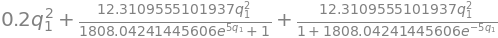

---

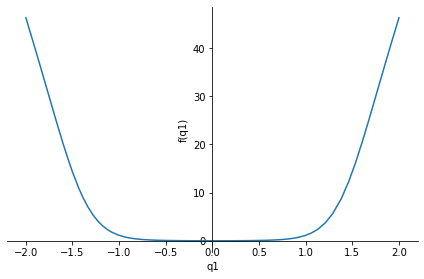

In [25]:

En = Eges.subs(params_values)

# Energy in upper equilibrium (used as scale for the penalty function)
Eooo = En.subz0(mod.xx) ##:

E_pen = penalty_expression(q1, -1.5, 1.5, m=5, scale=Eooo) + 0.2*q1**2 ##:
sp.plot(E_pen, (q1, -2, 2))

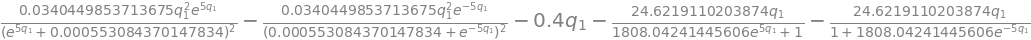

---

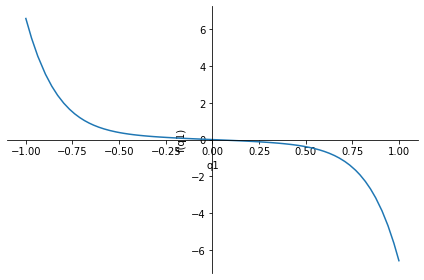

In [26]:
# Force driving the cart back to the center if it comes too close to the border
F_pen = -E_pen.diff(q1) ##:

sp.plot(F_pen, (q1, -1, 1))


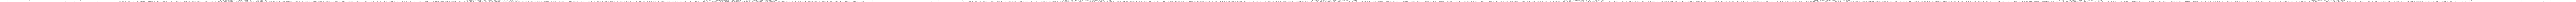

In [27]:
LgE = st.lie_deriv(Eges, mod.gg, mod.xx)

LgE 

## Create Simulation Model
without any actuation (i.e. no tranqulisation controller is active)

In [28]:
simmod = st.SimulationModel(mod.ff, mod.gg, mod.xx, model_parameters=params_values)

In [29]:
rhs = simmod.create_simfunction()


In [30]:
xx0 = np.array([2, 2, 2, 0,  0, 0, 0, 0])

In [31]:
from scipy.integrate import odeint

In [32]:
# simulate 5 seconds
tt = np.linspace(0, 15, 1000)
res = odeint(rhs, xx0, tt)  ##:S

---

In [33]:
Eges_subs = Eges.subs(params_values)
Eges_func = st.expr_to_func(mod.xx, Eges_subs)

In [34]:
Eges_subs.s ##:
mod.xx ##:T

---

(mod.xx).T := [p₁  p₂  p₃  q₁  ṗ₁  ṗ₂  ṗ₃  q̇₁]

---

In [35]:
# system energy at upper equilibrium
Eges_func(0, 0, 0, 0,  0, 0, 0, 0)

array(12.311)

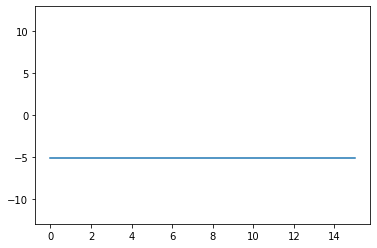

In [36]:
# check energy conservation

EE = Eges_func(*res[:, :].T)

plt.plot(tt, EE)
plt.ylim(-13, 13)


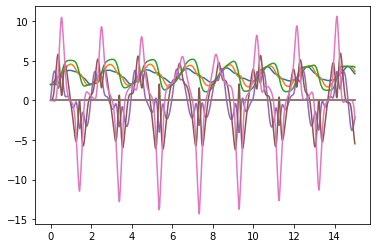

In [37]:
# plot state components 

plt.plot(tt, res)